In [62]:
import read_covid_data
import getLatestDataSets

getLatestDataSets.update_PCR_data()


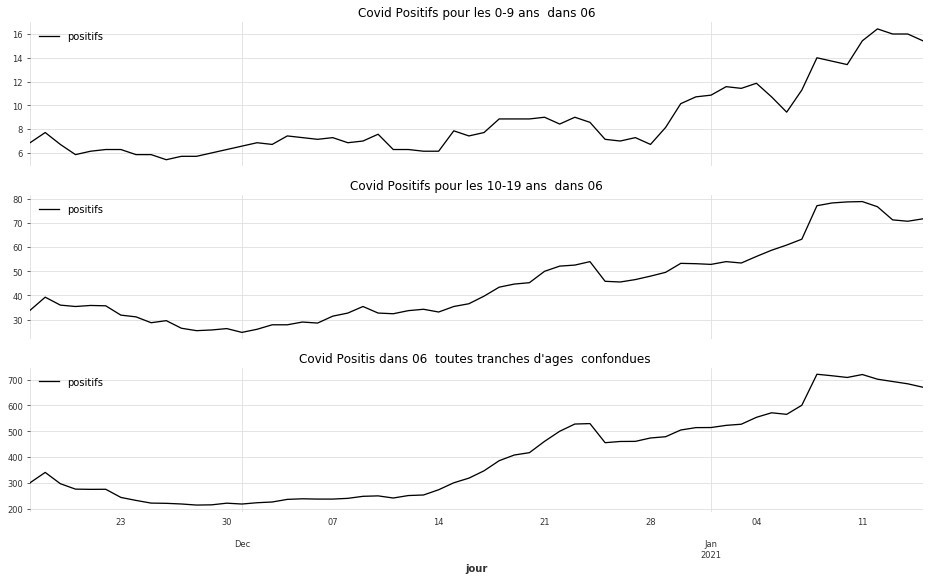

In [63]:

import matplotlib.pyplot as plt
import read_covid_data
import pandas as pd

raw_tests = read_covid_data.get_pcr_df()
d = '06'

pcr_kids_06= raw_tests.loc[ (raw_tests["cl_age90"]==9) & (raw_tests["dep"]==d),["jour","P","T","positivity"] ]
pcr_ados_06= raw_tests.loc[ (raw_tests["cl_age90"]==19) & (raw_tests["dep"]==d),["jour","P","T","positivity"] ]
pcr_all_ages_06= raw_tests.loc[ (raw_tests["cl_age90"]==0) & (raw_tests["dep"]==d),["jour","P","T","positivity"] ]
if not pcr_kids_06.empty:
    #Smoothing over one week in order to remove weekend distortions
    pcr_kids_06["positifs"] = pcr_kids_06["P"].rolling(7).mean()   
else:
    print ( "No PCR data for kids  in " + d)
if not pcr_ados_06.empty:
    #Smoothing over one week in order to remove weekend distortions
    pcr_ados_06["positifs"] = pcr_ados_06["P"].rolling(7).mean()   
else:
    print ( "No PCR data for ados  in " + d)
if not pcr_all_ages_06.empty:
    #Smoothing over one week in order to remove weekend distortions
    pcr_all_ages_06["positifs"] = pcr_all_ages_06["P"].rolling(7).mean()   
else:
    print ( "No PCR  data in " + d)


plt.rcParams["figure.figsize"] = [16,9]
fig, axs = plt.subplots(3,sharex=True)
pcr_kids_06.tail(60).plot(ax=axs[0],x="jour",y=["positifs"], title= "Covid Positifs pour les 0-9 ans  dans " + d ,grid=True)
pcr_ados_06.tail(60).plot(ax=axs[1],x="jour",y=["positifs"], title= "Covid Positifs pour les 10-19 ans  dans " + d ,grid=True)
pcr_all_ages_06.tail(60).plot(ax=axs[2],x="jour",y=["positifs"], title= "Covid Positis dans " +d+"  toutes tranches d'ages  confondues "  ,grid=True)


In [64]:
from darts import TimeSeries
pcr_all_ages_06_tseries = TimeSeries.from_dataframe(pcr_all_ages_06.tail(60), 'jour', 'positifs')

In [65]:
from darts.models import ExponentialSmoothing
train, val = pcr_all_ages_06_tseries.split_before(pd.Timestamp('20210107'))
model_ex = ExponentialSmoothing()
model_ex.fit(train)
prediction_ex = model_ex.predict(len(val))

C:\Users\hassa\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


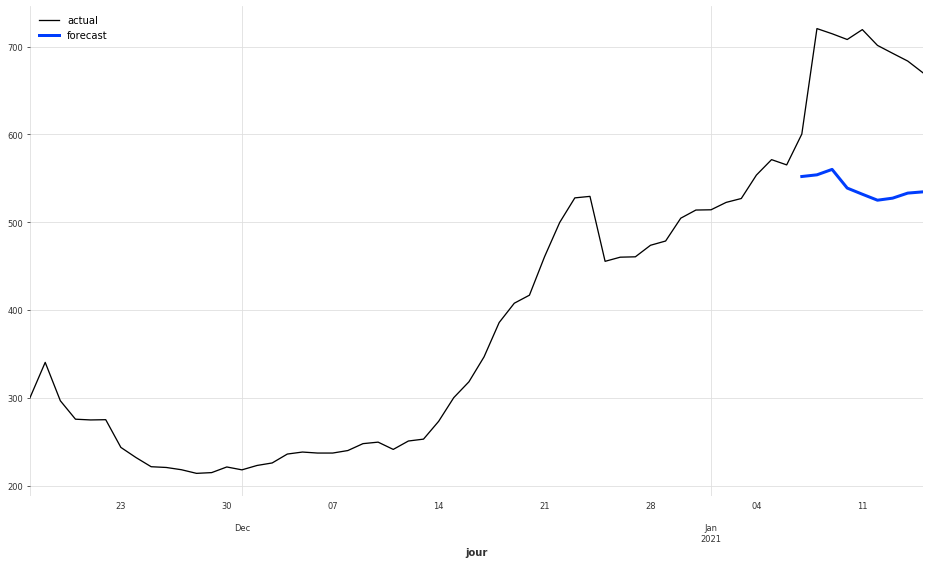

In [66]:
pcr_all_ages_06_tseries.plot(label='actual')
prediction_ex.plot(label='forecast', lw=3)
plt.legend()

In [67]:
from darts.models import AutoARIMA
model_aarima = AutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

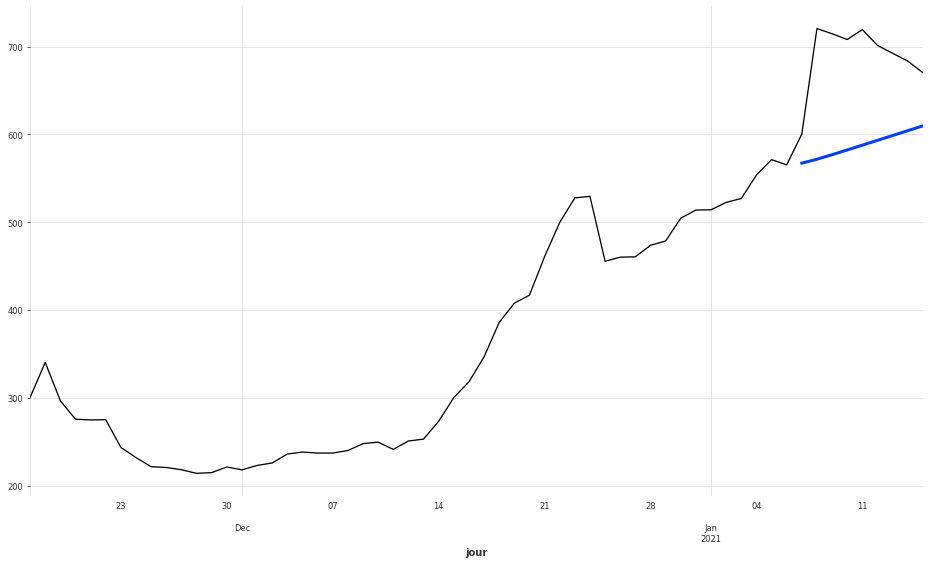

In [68]:
pcr_all_ages_06_tseries.plot(label='actual')
prediction_aarima.plot(label='forecast', lw=3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


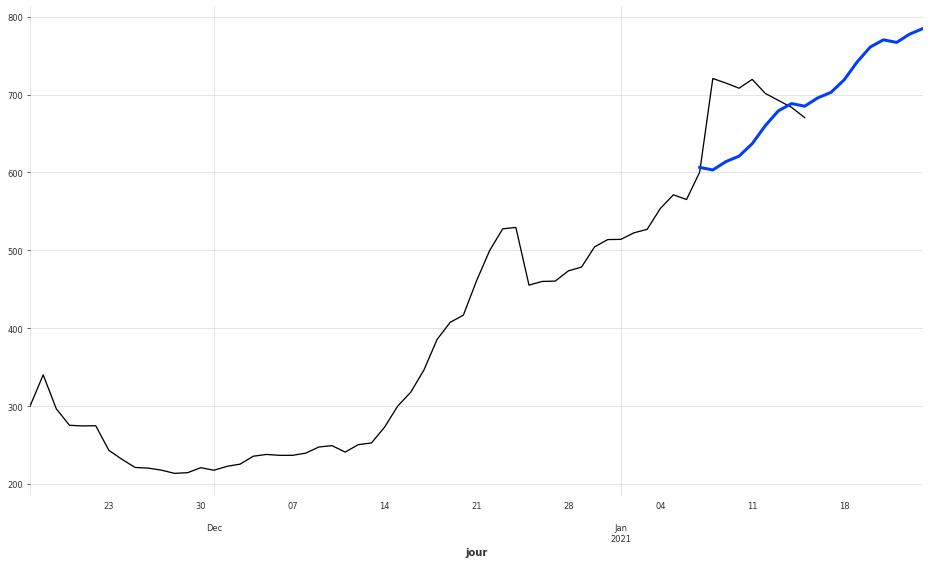

In [69]:
from darts.models import Prophet
model_prophet = Prophet()
model_prophet.fit(train)
prediction_prophet = model_prophet.predict(2*len(val))
pcr_all_ages_06_tseries.plot(label='actual')
prediction_prophet.plot(label='forecast Prophet', lw=3)

INFO:fbprophet:n_changepoints greater than number of observations. Using 22.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


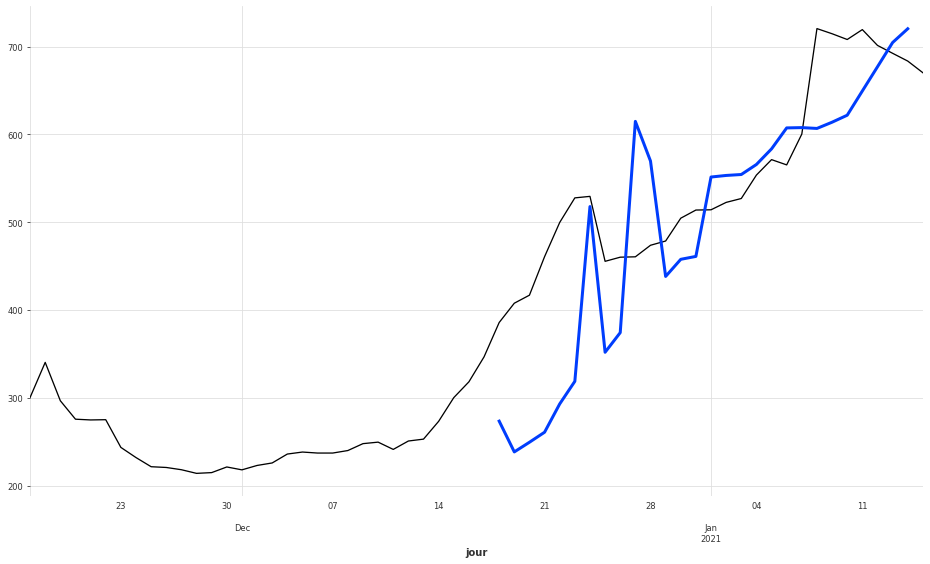

In [70]:
from darts.metrics import mape
model_prophet= Prophet(yearly_seasonality=False,daily_seasonality=False)
backtest_prophet = model_prophet.historical_forecasts(pcr_all_ages_06_tseries,
                            start=.5,
                            forecast_horizon=3)
err_prophet = mape(backtest_prophet, pcr_all_ages_06_tseries)
pcr_all_ages_06_tseries.plot(label='actual')
backtest_prophet.plot(lw=3, label='Prophet backtest, MAPE={:.2f}%'.format(err_prophet))

Auto-ARIMA MAPE: 17.410775173177274
C:\Users\hassa\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
[2021-01-19 06:25:11,013] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 25.
INFO:darts.utils.statistics:The ACF has no local maximum for m < max_lag = 25.
[2021-01-19 06:25:11,014] INFO | darts.models.theta | Theta model inferred seasonality of training series: 0
[2021-01-19 06:25:11,014] INFO | darts.models.theta | Theta model inferred seasonality of training series: 0
INFO:darts.models.theta:Theta model inferred seasonality of training series: 0
Prophet MAPE: 8.326571215862238
Exponential smoothing MAPE: 27.95328931350667
Theta(2) MAPE: 18.36038055037207
FFT(nr_freqs_to_keep=10, trend=None) MAPE: 156.25490042465387


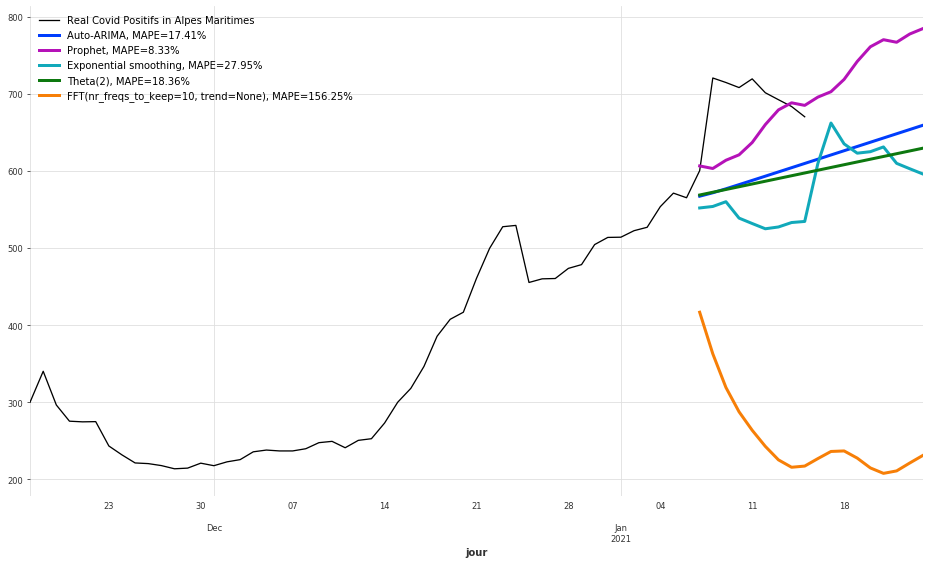

In [71]:
from darts.models import (
    FFT,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta
)
from darts.metrics import mape
models = [
    AutoARIMA(),
    Prophet(yearly_seasonality=False,daily_seasonality=False),
    ExponentialSmoothing(),
    Theta(),
    FFT()
]
pcr_all_ages_06_tseries.plot(label='Real Covid Positifs in Alpes Maritimes')
for model in models:
    model.fit(train)
    pred_val = model.predict(2*len(val))
    err= mape(pred_val, val)
    pred_val.plot(lw=3, label='{}, MAPE={:.2f}%'.format(str(model),err))
    print(str(model) + " MAPE: " + str(mape(pred_val, val)))
plt.legend()

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
# Number of previous time stamps taken into account.
SEQ_LENGTH = 21
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(pcr_all_ages_06_tseries)

covid_LSTM_model = RNNModel(
    model='LSTM',
    output_length=OUTPUT_LEN,
    hidden_size=HIDDEN_SIZE,
    n_rnn_layers=NUM_LAYERS,
    input_length=SEQ_LENGTH,
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3},
    model_name='COVID_LSTM',
    log_tensorboard=True,
    random_state=42
)

covid_LSTM_model.fit(train_transformed, val_training_series=val_transformed, verbose=True)

ValueError: high is out of bounds for int32